In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import math
import time

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, History, Callback, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from keras import backend as K



Using TensorFlow backend.


In [2]:
def prepare_training_data(df_F, df_D, df_Dt, d):
    
    DF = []
    for i in range(d):
        if i == 0:
            DF = np.concatenate((df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis = 1)
        else:
            DF = np.concatenate((DF, df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis=1)

    DF = DF[d:,:]
    Dy = np.concatenate((df_D.values, df_Dt.values), axis=1)
    Dy = Dy[d:,:]
    
    return DF, Dy

In [26]:
def train_test_split(DF, Dy, d, x_scaler, y_scaler, train_portion, set_length, n_sets):

    dim = np.shape(Dy)

    n_nodes = int(dim[1]/2)
    n_y = dim[1]
    x = np.linspace(0,1, n_nodes)

    #Scaling
    DFscaled = x_scaler.transform(DF)
    Dyscaled = y_scaler.transform(Dy)

    #X_train = DFscaled
    #Y_train = Dyscaled

    #Train test split
    #train_portion = 0.8
    n_features = int(DF.shape[1]/d)
    #n_timesteps = len(X_train[:,0])
    
    L = int(set_length*train_portion)
    U = int(set_length*(1-train_portion))
    
    x_train = np.zeros([n_sets*L, n_features*d])
    y_train = np.zeros([n_sets*L, n_y])
    
    x_test = np.zeros([n_sets, U, d, n_features])
    y_test = np.zeros([n_sets, U, n_y])
    
    for set_i in range(n_sets):
        X_i = DFscaled[set_length*set_i:set_length*(set_i+1),:]
        Y_i = Dyscaled[set_length*set_i:set_length*(set_i+1),:]
        x_train[L*set_i:L*(set_i+1),:] = X_i[0:L,:]
        y_train[L*set_i:L*(set_i+1),:] = Y_i[0:L,:]
        
        x_test_m = X_i[L:-1,:]
        y_test_m = Y_i[L:-1,:]
        
        x_test[set_i] = x_test_m.reshape((U, d, n_features))
        y_test[set_i] = y_test_m

    
    #Reshape training data into 3D array as required by the LSTM layer
    #Input shape is: (n_timesteps, d, n_features)
    x_train = x_train.reshape((x_train.shape[0], d, n_features))
    #x_test = x_test.reshape((x_test.shape[0], d, n_features))

    return x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x

In [4]:
def initialize_model(n_units, x_train, y_train, lr, n_layers):
    model = Sequential()
    
    #Add hidden layers, return_sequences=True if next layer is LSTM, False otherwise
    if n_layers == 1:
        model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
        
    elif n_layers == 2:
        model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
        model.add(LSTM(n_units))
    else: 
        model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
        for layer in range(n_layers-1):
            model.add(LSTM(n_units, return_sequences = True))
        model.add(LSTM(n_units))
    
    
    #model.add(Dropout(0.1))
    
    model.add(Dense(len(y_train[0,:]))) #Output Layer
    adam = Adam(lr=lr)
    model.compile(loss='mae', optimizer=adam)
    
    #Define callbacks
    history = History()
    earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=20, verbose=1, mode='auto')
    callback_list = [earlystop, history]
    return model, callback_list

In [5]:
def get_error(predictions, ytest):
    #Squared error is integrated numerically in space for each timestep and summed
    error = 0
    for i in range(len(predictions[:,0])):
        error += np.trapz((ytest[i,:] - predictions[i,:])**2, x)
    return error

In [6]:
def independent_predictions(x_test, my_model):

    input_i = np.copy(x_test[0,:,:]) #Initial conditions
    input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

    future_timesteps = len(x_test[:,0,0])-1
    preds = np.zeros([future_timesteps, n_y])

    force = np.copy(x_test[:,:,:(n_nodes)]) #Loading history for future timesteps, which is known
    for i in range(future_timesteps): 
        pred = my_model.predict(input_i_reshaped) #Predict next timestep
        preds[i, :] = pred[0] 

        input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
        input_i[d-1,:n_nodes] = force[i+1,d-1,:] #Fill in force for next timestep
        input_i[d-1,n_nodes:] = pred[0] #Fill in values that we just predicted

        input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer
        
    return preds

In [7]:
def independent_batch(x_batch):

    input_i = np.copy(x_batch[0,:,:]) #Initial conditions
    input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

    future_timesteps = len(x_batch[:,0,0])

    force = np.copy(x_batch[:,:,:(n_nodes)]) #Loading history for future timesteps, which is known
    
    ind_batch = np.zeros([future_timesteps, d, n_features])
    ind_batch[0] = input_i_reshaped[0]
    
    for i in range(future_timesteps): 
        pred = model.predict(input_i_reshaped) #Predict next timestep
        
        if i < future_timesteps - 1:
            input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
            input_i[d-1,:n_nodes] = force[i+1,d-1,:] #Fill in force for next timestep
            input_i[d-1,n_nodes:] = pred[0] #Fill in values that we just predicted

            input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer
            ind_batch[i+1] = input_i_reshaped[0]
        
    return ind_batch

In [8]:
def get_scalers(DF, Dy):
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    x_scaler.fit_transform(DF)
    y_scaler.fit_transform(Dy)
    
    return x_scaler, y_scaler

In [9]:
def get_batch_scalers(n_batches, training_set):
    
    #Simple version
    for i in range(n_batches):
        
        df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(i+1) + '.csv')
        df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(i+1) + '.csv')
        df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(i+1) + '.csv')
        
        if i == 0:  
            x_range = df_D.values.max() - df_D.values.min()
            imax = i
        
        else:
            new_x_range = df_D.values.max() - df_D.values.min()
            
            if new_x_range > x_range:
                x_range = new_x_range
                imax = i
                
    df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(imax+1) + '.csv')
    df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(imax+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(imax+1) + '.csv')
    
    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    return x_scaler, y_scaler

In [10]:
#columns = ['training set', 'n_layers', 'height', 'epochs', 'batch size', 'learning rate', 'early stopping', 'stop loss', 'Training Error', 'Test Error',
#           'Ind test error', 'Ind train error', 'Training time', 'Total time']
#df = pd.DataFrame(columns = columns)

#df.to_csv('../results/RNN_velocity_results.csv')

In [11]:
def get_batch(x_train, y_train, batch_size, set_length, n_sets):
    
    set_number = randint(0, n_sets)
    start = random.randint(0,set_length-batch_size)*set_number*set_length
    
    x_batch = x_train[start:start+batch_size]
    y_batch = y_train[start:start+batch_size]
    
    return x_batch, y_batch

In [12]:
class Ind_pred(Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        
        error = 0
        if epoch > 400 or epoch%10 == 0:
            input_i = np.copy(x_test[0,:,:]) #Initial conditions
            #input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

            future_timesteps = len(x_test[:,0,0])-1
            preds = np.zeros([future_timesteps, n_y])

            force = np.copy(x_test[:,:,0]) #Loading history for future timesteps, which is known

            new_step = np.zeros(len(x_test[0,0,:]))
            input_shape = input_i.shape

            for i in range(future_timesteps): 

                input_i_pca = pca.transform(input_i.reshape([input_shape[0], input_shape[1]]))

                pred = self.model.predict(input_i_pca.reshape([1,d,n_features])) #Predict next timestep
                preds[i, :] = pred[0] 

                input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
                new_step[0] = force[i+1,d-1] #Fill in force for next timestep
                new_step[1:] = pred[0] #Fill in values that we just predicted


                input_i[d-1,:] = new_step.reshape([1,len(new_step)])


            error = 0
            for i in range(len(preds[:,0])):
                error += np.trapz((y_test[i,:n_nodes] - preds[i,:n_nodes])**2, x)

        info = {'ind error': error}
        u_ind_errors.append(error)

        logs['ind_error'] = error

        print(info)
    
    #def on_batch_end(self, batch, logs={}):
    #    print(batch)

In [13]:
def independent_predictions_pca(x_test, my_model):        
    input_i = np.copy(x_test[0,:,:]) #Initial conditions
    #input_i_reshaped = input_i.reshape((1,d,n_features)) #Reshape to fit LSTM layer

    future_timesteps = len(x_test[:,0,0])-1
    preds = np.zeros([future_timesteps, n_y])

    force = np.copy(x_test[:,:,0]) #Loading history for future timesteps, which is known

    new_step = np.zeros(len(x_test[0,0,:]))
    input_shape = input_i.shape

    for i in range(future_timesteps): 

        input_i_pca = pca.transform(input_i.reshape([input_shape[0], input_shape[1]]))

        pred = my_model.predict(input_i_pca.reshape([1,d,n_features])) #Predict next timestep
        preds[i, :] = pred[0] 

        input_i[0:d-1,:] = input_i[1:d,:] #Move everything one step backward
        new_step[0] = force[i+1,d-1] #Fill in force for next timestep
        new_step[1:] = pred[0] #Fill in values that we just predicted


        input_i[d-1,:] = new_step.reshape([1,len(new_step)])
        
    return preds

In [208]:
#Mass import

#X_train = np.zeros([95,34200,d,n_features]) 
#DF_total = np.zeros()
training_set = 'mass_production_white_noise_component_test'
d = 20
train_portion = 0.95
n = 18
s = 36000-d-1
DF_total = np.zeros([s*n, 21*d])
Dy_total = np.zeros([s*n, 20])

for i in range(n):

    iteration = i #5*i+5

    #Import training data
    df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(iteration) + '.csv')
    df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(iteration) + '.csv')
    df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(iteration) + '.csv')

    #Prepare training data
    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    DF_total[i*s:s*(i+1),:] = DF
    Dy_total[i*s:s*(i+1),:] = Dy
    
    

In [164]:
DF_total.shape

(215874, 420)

In [165]:
# Get scalers
x_scaler, y_scaler = get_scalers(DF_total, Dy_total)


In [209]:
#Split into train and test set
x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF_total, Dy_total, d, x_scaler, y_scaler, 
                                                                                 train_portion, s, n)

In [167]:
####Method 1####
train_shape = x_train.shape
test_shape = x_test.shape

x_train2 = x_train.reshape([train_shape[0]*train_shape[1],train_shape[2]])
#x_test2 = x_test.reshape([test_shape[0]*test_shape[1],test_shape[2]])

NCOMPONENTS = 5

pca = PCA(n_components=NCOMPONENTS)
X_pca_train = pca.fit_transform(x_train2)
#X_pca_test = pca.transform(x_test2)
pca_std = np.std(X_pca_train)

In [168]:
x_train.shape

(205080, 20, 21)

In [169]:
sh1 = X_pca_train.shape
#sh2 = X_pca_test.shape
x_train_pca = X_pca_train.reshape([int(sh1[0]/d),d,sh1[1]])
#x_test_pca = X_pca_test.reshape([int(sh2[0]/d),d,sh2[1]])

In [170]:
set_length = int(x_train_pca.shape[0]/n)
#test_set_length = int(x_test_pca.shape[0]/n)

In [171]:
######################### BATCH TRAINING ########################################

n_batches = 1
#d = 10

#Hyperparameter settings
epochs = 100
layers = 1
height = 100
batch_size = 1000
lr = 0.01
u_errors_matrix = []
c_errors_matrix =[]

In [211]:
n_features = sh1[1]

In [173]:
############## train_on_batch #####################
t0 = time.time()
bt_model = Sequential()
#u_model.add(LSTM(height, input_shape=(sh1[1], n_features), return_sequences=True))
#u_model.add(LSTM(height, return_sequences=False))
bt_model.add(LSTM(height, batch_input_shape=(None, d, n_features), return_sequences=False))
#bt_model.add(LSTM(height, return_sequences=False))
#model.add(Dropout(0.1))
bt_model.add(Dense(len(y_train[0,:]))) #Output Layer
adam = Adam(lr=lr)
bt_model.compile(loss='mae', optimizer=adam)
#Define callbacks
ind_pred = Ind_pred()
history = History()
earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=15, min_lr=0.0001, mode='min', verbose=1)
model_cp = ModelCheckpoint('../results/model_checkpoint.h5', monitor='ind_error', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
#hist = u_model.fit(x_train_pca, y_train, epochs=epochs, callbacks=[ind_pred, history, earlystop, reduce_lr, model_cp], batch_size=batch_size, 
#                   verbose=1, shuffle=False)

bt_ind_errors = []


In [179]:

batch_size = 1000
n_sets = n
batch_iterations = int(set_length/batch_size)*n_sets
lowest = 1
since_lowest = 0
patience = 5
losses = np.zeros(batch_iterations)
for tr_set in range(1):
    for epoch in range(epochs):
        for bi in range(batch_iterations):
            
            set_number = random.randint(0, n_sets-1)
            start = set_number*set_length + random.randint(0,set_length-batch_size)

            x_batch = x_train_pca[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            hist = bt_model.train_on_batch(x_batch, y_batch)
            
            losses[bi] = hist
            
        
        avg_loss = losses.mean()
        
        if epoch > 200:
            bt_pred_ind_all = independent_predictions_pca(x_test, bt_model)
            bt_pred_ind = bt_pred_ind_all[:, 0]
            bt_ind_error = get_error(bt_pred_ind, y_test_r[0:len(bt_pred_ind),0])

            bt_ind_errors.append(bt_ind_error)
        elif epoch%10 == 0:
            
            test_set_number = random.randint(0, n_sets-1)
            #start = set_number*set_length
            x_test_r = x_test[test_set_number]
            y_test_r = y_test[test_set_number]
            
            bt_pred_ind_all = independent_predictions_pca(x_test_r, bt_model)
            bt_pred_ind = bt_pred_ind_all[:, 0:n_nodes]
            bt_ind_error = get_error(bt_pred_ind, y_test_r[0:len(bt_pred_ind),0:n_nodes])

            bt_ind_errors.append(bt_ind_error)
        else:
            bt_ind_error = 0

        if avg_loss < lowest:
            lowest = avg_loss
            reduce = 'no'
            since_lowest = 0
        else: 
            if since_lowest == patience:
                
                if lr >= 0.0001:
                    lr *= 0.2
                    K.set_value(bt_model.optimizer.lr, lr)
                    reduce = 'yes'
                    since_lowest = 0
                elif lr > 0.00001:
                    K.set_value(bt_model.optimizer.lr, 0.00001)
                    lr = 0.00001
                    reduce = 'yes'
                    since_lowest = 0
            else:
                since_lowest += 1
                reduce = 'no' 
        
        info = {'epoch':epoch, 'loss': avg_loss, 'lr': lr, 'reduce': reduce, 'since_lowest': since_lowest}
        print(info)
        print({'ind_error': bt_ind_error})
        
#earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=20, verbose=1, mode='auto')
#callback_list = [earlystop, history]
print({'total time': time.time()-t0})

{'epoch': 0, 'loss': 0.00036561174562723634, 'lr': 0.002, 'reduce': 'no', 'since_lowest': 0}
{'ind_error': 3.5933911977825828}
{'epoch': 1, 'loss': 0.00037699081889620763, 'lr': 0.002, 'reduce': 'no', 'since_lowest': 1}
{'ind_error': 0}
{'epoch': 2, 'loss': 0.000398538242734503, 'lr': 0.002, 'reduce': 'no', 'since_lowest': 2}
{'ind_error': 0}
{'epoch': 3, 'loss': 0.00035832667979811245, 'lr': 0.002, 'reduce': 'no', 'since_lowest': 0}
{'ind_error': 0}
{'epoch': 4, 'loss': 0.00037686248534180993, 'lr': 0.002, 'reduce': 'no', 'since_lowest': 1}
{'ind_error': 0}
{'epoch': 5, 'loss': 0.00036223930153794878, 'lr': 0.002, 'reduce': 'no', 'since_lowest': 2}
{'ind_error': 0}
{'epoch': 6, 'loss': 0.00037531833660585677, 'lr': 0.002, 'reduce': 'no', 'since_lowest': 3}
{'ind_error': 0}
{'epoch': 7, 'loss': 0.00036577905227793106, 'lr': 0.002, 'reduce': 'no', 'since_lowest': 4}
{'ind_error': 0}
{'epoch': 8, 'loss': 0.00037070808649136157, 'lr': 0.002, 'reduce': 'no', 'since_lowest': 5}
{'ind_error'

KeyboardInterrupt: 

In [213]:
#Total ind_error

total_error = 0
n_sets = 18
errors = []
for j in range(n_sets):

    x_test_r = x_test[j]
    y_test_r = y_test[j]

    bt_pred_ind_all = independent_predictions_pca(x_test_r, bt_model)
    bt_pred_ind = bt_pred_ind_all[:, 0:n_nodes]
    bt_ind_error = get_error(bt_pred_ind, y_test_r[0:len(bt_pred_ind[:,0]),0:n_nodes])
    total_error += bt_ind_error
    errors.append(bt_ind_error)

print(errors)
print(total_error)

[71.420433292447811, 62.97194219059817, 35.63405957375263, 44.688502092053746, 23.787748179728734, 40.30948374070158, 19.893993458133398, 11.427520434368523, 12.241449473860595, 8.4851333706293151, 4.6466550285270332, 2.3368413274890085, 2.8031536356152382, 1.4410074206870411, 1.8167367047197185, 0.50214013144830716, 0.35022701577432441, 0.29662330047287572]
345.053650371


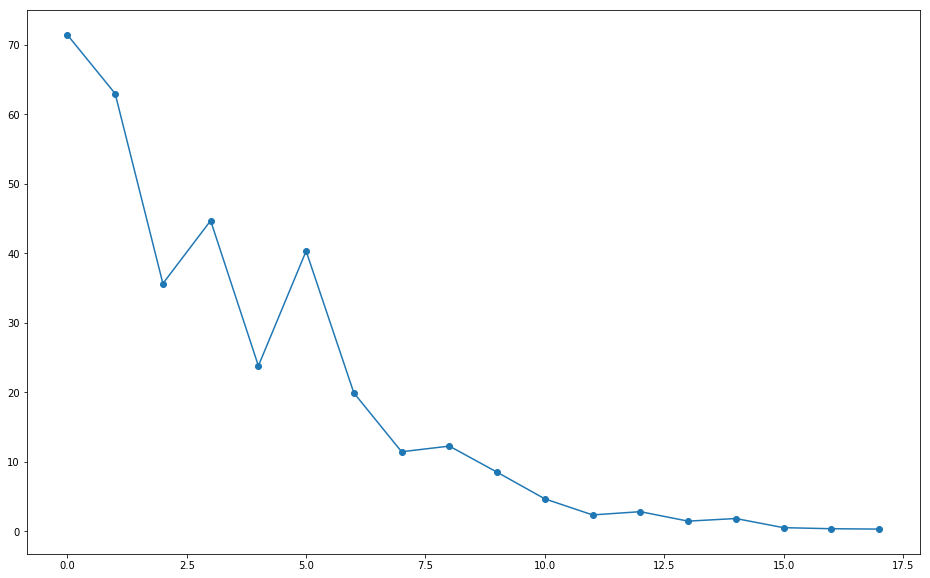

In [221]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
#plt.plot(bt_pred_ind[:,n_nodes-1])

#plt.plot(y_test_r[0:, n_nodes-1])
plt.plot(errors, '-o')

plt.show()

In [217]:

j = 0
x_test_r = x_test[j]
y_test_r = y_test[j]

bt_pred_ind_all = independent_predictions_pca(x_test_r, bt_model)
bt_pred_ind = bt_pred_ind_all[:, 0:n_nodes]
bt_ind_error = get_error(bt_pred_ind, y_test_r[0:len(bt_pred_ind[:,0]),0:n_nodes])
print(bt_ind_error)

71.4204332924


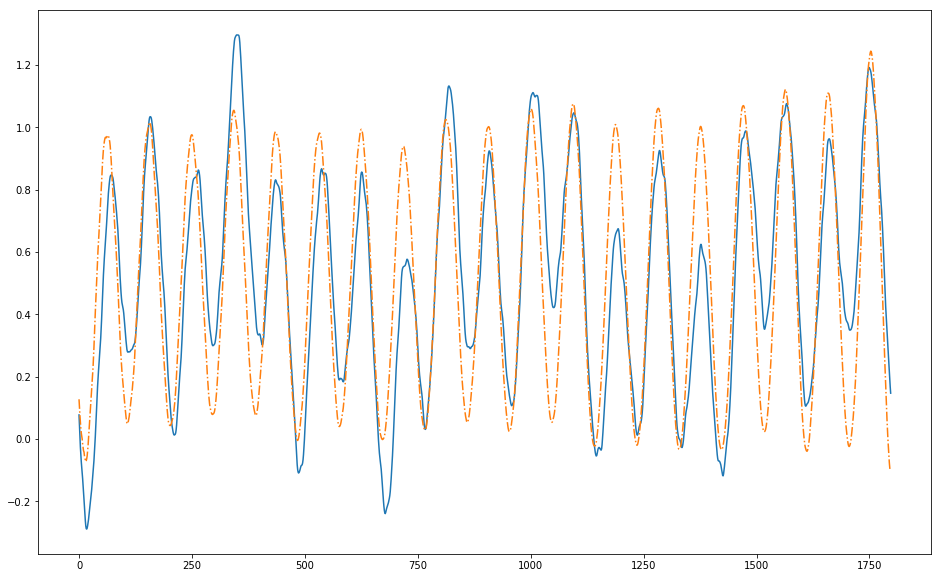

In [218]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
#plt.plot(bt_pred_ind[:,n_nodes-1])

plt.plot(y_test_r[0:, n_nodes-1])
plt.plot(bt_pred_ind[0:,n_nodes-1], '-.')

plt.show()

In [413]:
##################### UNSEEN DATA ###################

#Select training set
training_set = 'unseen1'
iteration = 0
#d = 10
train_portion = 0.95

#Import training data
df_D = pd.read_csv('../training_batches/'+ training_set +'D' + str(iteration) + '.csv')
df_F = pd.read_csv('../training_batches/'+ training_set +'F' + str(iteration) + '.csv')
df_Dt = pd.read_csv('../training_batches/'+ training_set +'Dt' + str(iteration) + '.csv')

#Prepare training data
DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)

#Get global scalers
#x_scaler, y_scaler = get_scalers(DF, Dy)

#Split into train and test set
x_unseen_train, x_unseen_test, y_unseen_train, y_unseen_test, n_nodes, n_features, n_y, x = train_test_split(DF[:,:], Dy[:,:], d, x_scaler, y_scaler, train_portion)
n_features = sh1[1]

In [414]:
f_pred_ind_all = independent_predictions_pca(x_unseen_test, f_model)
f_pred_ind = f_pred_ind_all[:, 0:n_nodes]

In [415]:
f_ind_error = get_error(f_pred_ind, y_unseen_test[0:len(f_pred_ind[:,0]),0:n_nodes])
print(f_ind_error)

461.575430303


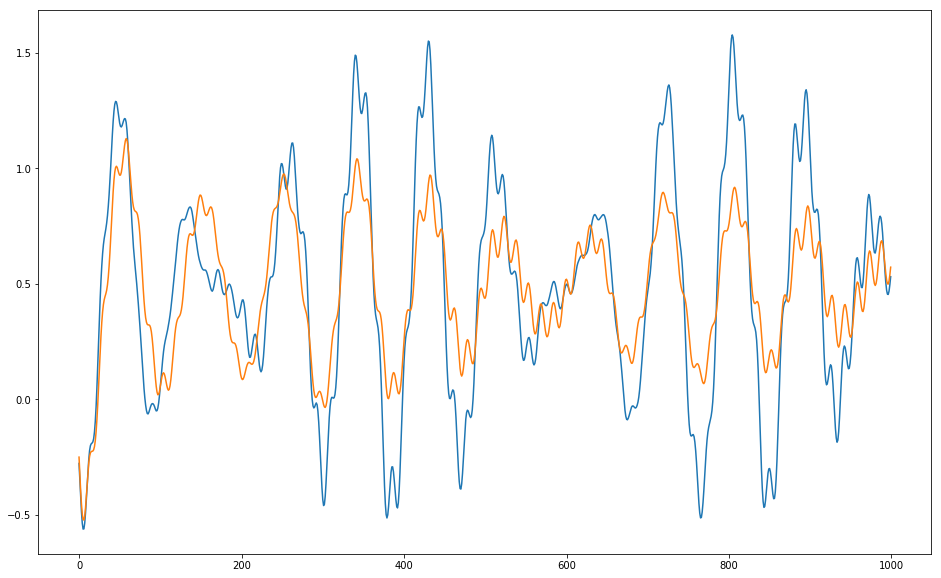

In [416]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
#plt.plot(bt_pred_ind[:,n_nodes-1])

plt.plot(y_unseen_test[:1000, n_nodes-1])
plt.plot(f_pred_ind[:1000,n_nodes-1])

plt.show()

In [332]:
f_model.predict(pca.transform(x_unseen_test[0,:,:]).reshape([1,d,n_features]))

array([[ 0.41883656,  0.41931304,  0.41766015,  0.41867629,  0.42105049,
         0.42189106,  0.4251999 ,  0.44010538,  0.45728752,  0.46517229,
         0.53769237,  0.53808057,  0.53931403,  0.5402357 ,  0.54199147,
         0.54450291,  0.54377806,  0.56265378,  0.52699947,  0.50802404]], dtype=float32)

In [344]:
len(f_model.get_weights())

5

In [392]:
#save best model
#trained on= rr_set1

#f_model.save('../models/lin_white_noise_dt01.h5')

#### CONTINUE TRAINING ####
#f_model = keras.modelload_model('../models/RNN_gr_set1.h5')

#model.fit(x_train, y_train, epochs=100, verbose=1)

#model.save('beam_model.h5')

#del(model)

In [136]:
def generate_export(my_model):
    pred_train_all = my_model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]

    pred_test_all = my_model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]

    pred_ind_all = independent_predictions(x_test, my_model)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]

    y_test_u = y_scaler.inverse_transform(y_test)[:, 0:n_nodes]
    
    #Export results
    np.savetxt("../results/predictions.csv", pred_test_u, delimiter=",")
    np.savetxt("../results/preds.csv", pred_ind_u, delimiter=",")
    np.savetxt("../results/y_test.csv", y_test_u, delimiter=",")
    np.savetxt("../results/y_train.csv", y_test_u, delimiter=",")

In [316]:
#generate_export(u_model)

In [183]:
y_test_u = y_scaler.inverse_transform(y_test_r)[:, 0:n_nodes]
bt_pred_ind_u = y_scaler.inverse_transform(bt_pred_ind_all)[:, 0:n_nodes]

In [184]:
#Export results
#np.savetxt("../results/predictions.csv", pred_test_u, delimiter=",")
np.savetxt("../results/preds.csv", bt_pred_ind_u, delimiter=",")
np.savetxt("../results/y_test.csv", y_test_u, delimiter=",")
#np.savetxt("../results/y_train.csv", y_test_u, delimiter=",")

In [232]:
# one layer, height 500, gives lowest error around 9, but this is while its heavily overfitting
# one layer, height 100, on gr_set1 goes down to about 6 at epoch 40, then starts overfitting
# same, but with height 200 starts oscillating around batch 20, then the ind error is around 9. 
# With dropout 0.1 the results are bad


#df = df.drop(columns=df.columns[0])
#df.to_csv('../results/RNN_velocity_results.csv')

In [233]:
#pd.read_csv('../results/RNN_velocity_results.csv', index_col=0)

,training set,n_layers,height,epochs,batch size,learning rate,early stopping,stop loss,Training Error,Test Error,Ind test error,Ind train error,Training time,Total time
0,rr,2,100,500,1000,0.0005,115,0.005931,0.428430,0.102271,4.126604,19.038270,2173.341693,2263.469776
1,rr,2,100,500,1000,0.0001,36,0.005536,0.457434,0.111018,18.604378,96.249718,707.928417,803.638126
2,rr,3,50,500,1000,0.0005,160,0.013542,0.497549,0.108562,11.480535,70.656266,5234.750504,5392.588225


In [202]:
#save best model
#trained on= gr_set1

#u_model.save('../models/RNN_rr_set3_5e.h5')

#### CONTINUE TRAINING ####
#model = load_model('beam_model.h5')

#model.fit(x_train, y_train, epochs=100, verbose=1)

#model.save('beam_model.h5')

#del(model)

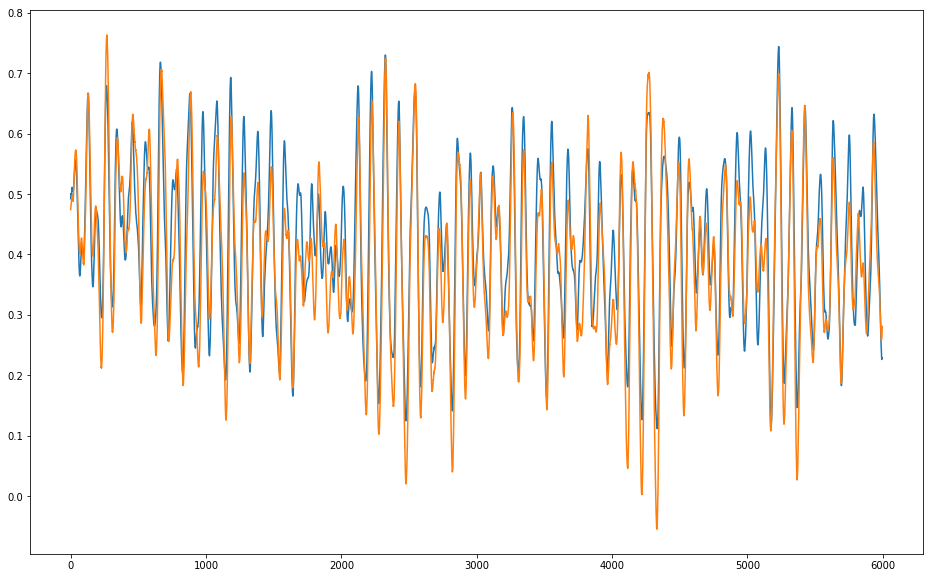

{'Iteration number': 1, 'Training Error': 1.7276860353577641, 'Test Error': 0.29846556877570002, 'Ind test error': 18.855915684260651, 'Training time': 0.0, 'Total time': 34.77224016189575}


In [32]:
######################### BATCH TESTING ########################################

n_batches = 1
#d = 8

t0 = time.time()
for iteration in range(n_batches):

    df_D = pd.read_csv('../training_batches/rrD' + str(iteration+1) + '.csv')
    df_F = pd.read_csv('../training_batches/rrF' + str(iteration+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/rrDt' + str(iteration+1) + '.csv')

    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    
    #if i == 0:
    #    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF, Dy, d, x_scaler, y_scaler)
    
    ts = time.time()
    #if i == 0:
    #    model, callback_list = initialize_model(100, x_train, y_train)
    
    #model.fit(x_train, y_train, epochs=100, callbacks=callback_list, batch_size=len(x_train), verbose=0, shuffle=False)
    
    training_time = time.time() - ts
    
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    y_test_u = y_scaler.inverse_transform(y_test)[:, 0:n_nodes]
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    
    plt.figure(figsize=(16,10))
    #plt.plot(pred_test[:,n_nodes-1], 'x')
    plt.plot(pred_ind[:,n_nodes-1])
    plt.plot(y_test[:, n_nodes-1])
    plt.show()

    
    total_time = time.time() - t0
    
    info = {'Iteration number': iteration+1, 'Training Error': training_error, 'Test Error': test_error, 'Ind test error': ind_error,
            'Training time': training_time, 'Total time': total_time}
    print(info)

In [202]:
#Export results
np.savetxt("../results/predictions.csv", pred_test_u, delimiter=",")
np.savetxt("../results/preds.csv", pred_ind_u, delimiter=",")
np.savetxt("../results/y_test.csv", y_test_u, delimiter=",")
np.savetxt("../results/y_train.csv", y_test_u, delimiter=",")

In [203]:
pred_ind_all = independent_predictions(x_train)
pred_ind = pred_ind_all[:, 0:n_nodes]

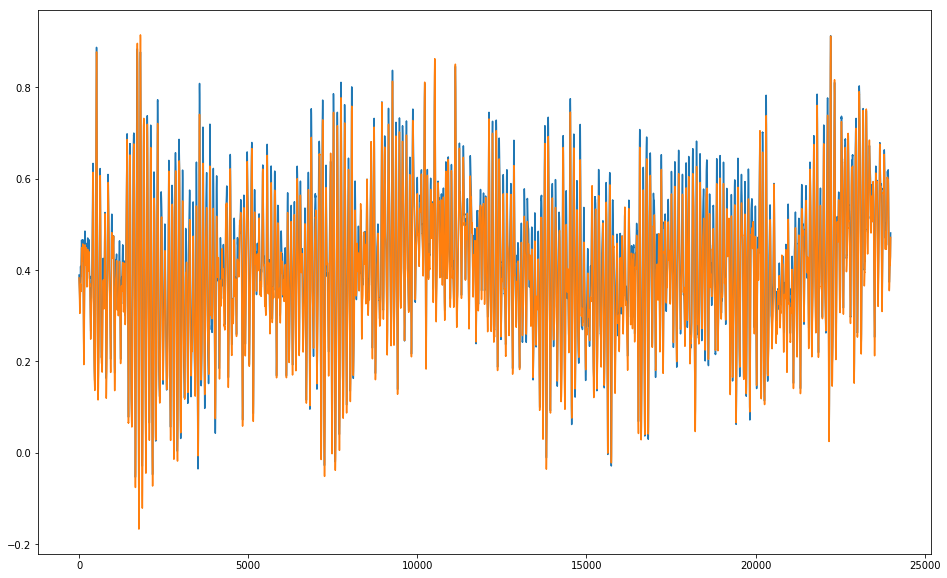

In [204]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
plt.plot(pred_ind[:,n_nodes-1])
plt.plot(y_train[:, n_nodes-1])
plt.show()

In [89]:
DF.shape

(4995, 205)

In [91]:
df_D.values.shape

(5000, 21)

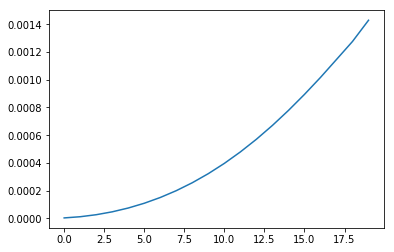

In [20]:
plt.plot(y_test_u[50,:])